In [1]:
import pickle
from scipy.sparse import csr_matrix
from clustering import visualize_silhouette_clusters, compare_true_labels
import numpy as np
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from soyclustering import SphericalKMeans, visualize_pairwise_distance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns


with open('data/mnist/minsupp_0.26/itemset_features.pkl', 'rb') as f:
    itemset_features = pickle.load(f)
    
with open('data/mnist_labels.pkl', 'rb') as f:
    true_labels = pickle.load(f)
    
print("num of groundtruth labels:", len(np.unique(true_labels)))

num of groundtruth labels: 10


In [2]:
#subsample because dataset is too big

subsample_indices = np.random.choice(len(itemset_features),5000,replace=False)
itemset_features = itemset_features[subsample_indices]
true_labels = true_labels[subsample_indices]

In [3]:
# adjust number of clusters
my_num_clusters = 10

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
itemset_matrix = csr_matrix(itemset_features.astype(int))
density = itemset_matrix.getnnz() / np.prod(itemset_matrix.shape)
print("density of matrix:", density)

spherical_kmeans = SphericalKMeans(
        n_clusters=my_num_clusters,
        max_iter=100,
        verbose=0,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

results = []
i=0
while len(results)<10:
    try:
        sphkmeans_cluster_labels = spherical_kmeans.fit_predict(itemset_matrix)
        i+=1
        print('\nRun #' + str(i))
        result = compare_true_labels(true_labels, sphkmeans_cluster_labels, itemset_features)
        results.append(result)
    except Exception as e:
        # sometimes spherical clustering fails due to the initialization, re-run
        print(e)
        continue 

density of matrix: 0.30066366585563664

Run #1
Adjusted Rand Index: 0.2241778407056581
Normalized Mutual Information: 0.3372213119869848
Homogeneity: 0.3362136360586421
Completeness: 0.3382350463444566
V-Measure: 0.3372213119869848
Silhouette Score: 0.08789158463152084

Run #2
Adjusted Rand Index: 0.20928433065075877
Normalized Mutual Information: 0.32530531904128546
Homogeneity: 0.3245571781121079
Completeness: 0.3260569170379667
V-Measure: 0.3253053190412855
Silhouette Score: 0.08743409581719568

Run #3
Adjusted Rand Index: 0.22295644168623557
Normalized Mutual Information: 0.3422408063700919
Homogeneity: 0.34093766626183863
Completeness: 0.3435539464872428
V-Measure: 0.3422408063700919
Silhouette Score: 0.09219866238477888

Run #4
Adjusted Rand Index: 0.22032625142424425
Normalized Mutual Information: 0.33770901539414977
Homogeneity: 0.33643163353734223
Completeness: 0.33899613428636655
V-Measure: 0.3377090153941497
Silhouette Score: 0.09237809134281041

Run #5
Adjusted Rand Index: 

In [4]:
results = np.array(results)
column_medians = np.median(results, axis=0)

print("Median values")
print("ARI: " + str(column_medians[0]))
print("NMI: " + str(column_medians[1]))
print("Homogeneity: " + str(column_medians[2]))
print("Completeness: " + str(column_medians[3]))
print("V-Measure: " + str(column_medians[4]))
print("Silhouette: " + str(column_medians[5]))

Median values
ARI: 0.2234140316649733
NMI: 0.338893290293523
Homogeneity: 0.3377809911730262
Completeness: 0.3400131109879903
V-Measure: 0.338893290293523
Silhouette: 0.09048887785230553


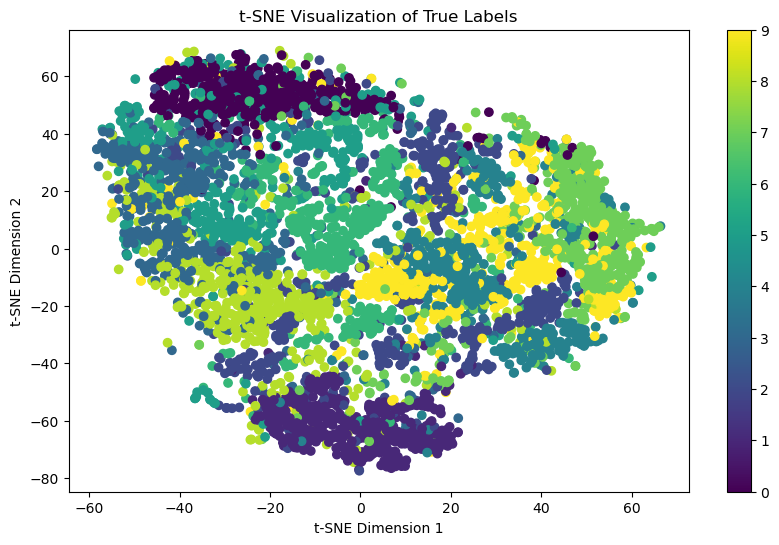

In [5]:
## using t-sne (alternative to pca) to visualize clusters according to true labels

# Calculate cosine distances between binary vectors
#cosine_distances_matrix = cosine_distances(itemset_features)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="cosine", perplexity=50, learning_rate=(len(itemset_features)/48), n_iter=5000, n_jobs=-1, early_exaggeration=16)

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(itemset_features)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))


plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


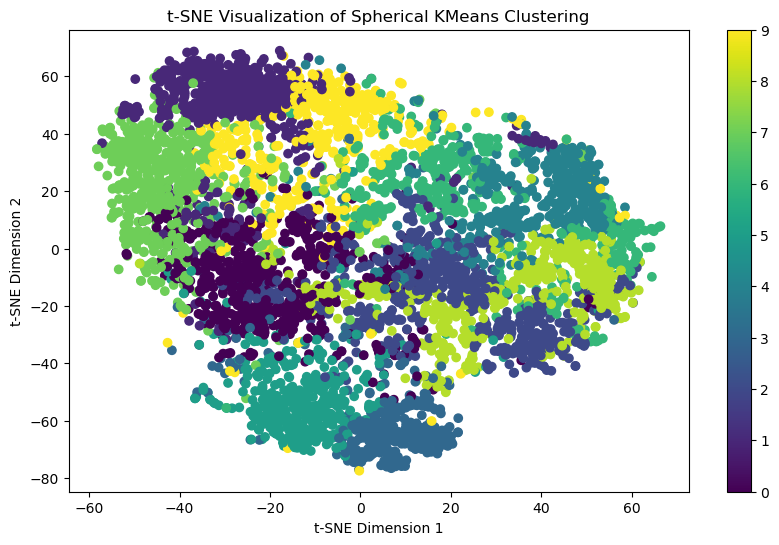

In [6]:
## using t-sne (alternative to pca) to visualize Spherical KMeans clusters

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Spherical KMeans Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


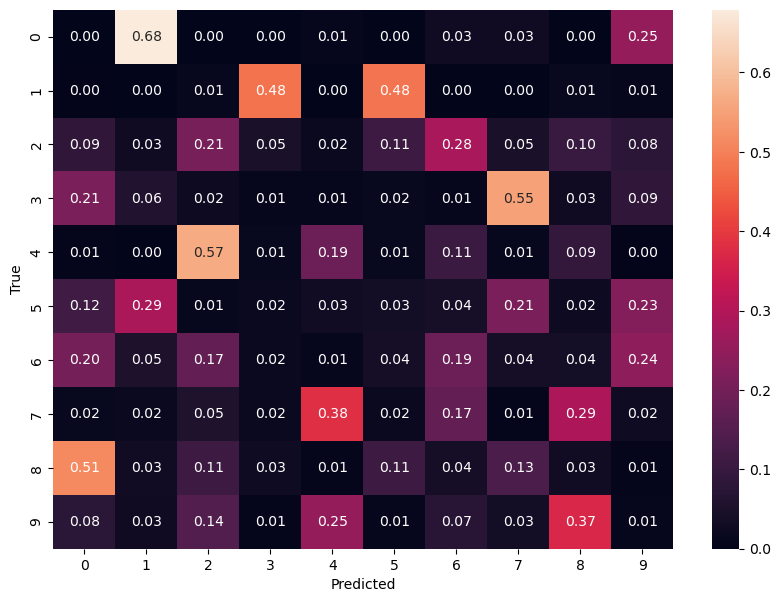

In [7]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, sphkmeans_cluster_labels, normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

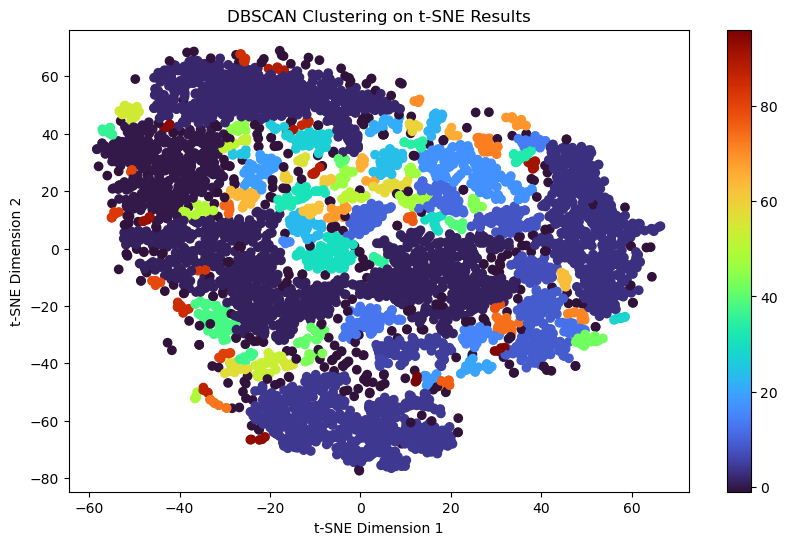

Adjusted Rand Index: 0.30726367158980317
Normalized Mutual Information: 0.44532950421358264
Homogeneity: 0.5187242777051682
Completeness: 0.3901296959574298
V-Measure: 0.44532950421358264
Silhouette Score: -0.12228917009877208


array([ 0.30726367,  0.4453295 ,  0.51872428,  0.3901297 ,  0.4453295 ,
       -0.12228917])

In [8]:
## performing DBSCAN on the data transformed by t-sne

from sklearn.cluster import DBSCAN

# Apply DBSCAN to the t-SNE results
dbscan = DBSCAN(eps=2, min_samples=5)
dbscan_labels = dbscan.fit_predict(tsne_results)

# Create a scatter plot to visualize the DBSCAN clustering results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='turbo')
plt.colorbar()
plt.title('DBSCAN Clustering on t-SNE Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

compare_true_labels(true_labels, dbscan_labels, itemset_features)

In [11]:
# OPTIMISING DBSCAN PARAMETERS USING SILHOUETTE SCORE

from hyperopt import hp, fmin, tpe, Trials
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

# Define the search space
space = {
    'eps': hp.uniform('eps', 6.6, 20),
    'min_samples': hp.choice('min_samples', range(2, 50))
}

# Define the objective function
def objective(params):
    dbscan = DBSCAN(**params)
    cluster_labels = dbscan.fit_predict(tsne_results)

    # Exclude noise points (labelled as -1) before computing the silhouette score
    non_noise_indices = np.where(cluster_labels != -1)[0]
    if len(non_noise_indices) == 0 or len(set(cluster_labels[non_noise_indices])) == 1:
        # Return a large negative value if there's only one cluster or all are noise 
        # since silhouette score can't be computed in these cases
        return 1

    # score = silhouette_score(itemset_features[non_noise_indices], cluster_labels[non_noise_indices], metric='cosine')
    score = silhouette_score(tsne_results[non_noise_indices], cluster_labels[non_noise_indices])
    return -score  # Negative score because fmin tries to minimize the objective

# Run the optimizer
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=300  # Number of evaluations
)

best_min_samples = range(2, 50)[best['min_samples']]
best_eps = best['eps']
print("Best eps:", best['eps'])
print("Best min_samples:", best_min_samples)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.34trial/s, best loss: -0.32052457332611084]
Best eps: 6.636630058037692
Best min_samples: 46


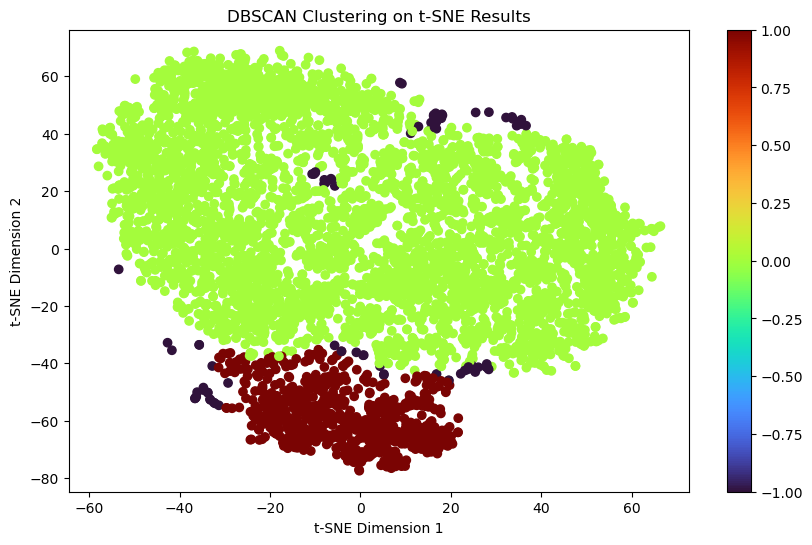

Adjusted Rand Index: 0.049858543192494956
Normalized Mutual Information: 0.19337831377907597
Homogeneity: 0.11426950322249838
Completeness: 0.6284644065319284
V-Measure: 0.19337831377907597
Silhouette Score: 0.10151350241263288


In [12]:
# Apply DBSCAN to the t-SNE results
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(tsne_results)

# Create a scatter plot to visualize the DBSCAN clustering results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='turbo')
plt.colorbar()
plt.title('DBSCAN Clustering on t-SNE Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

non_noise_indices = np.where(dbscan_labels != -1)[0]
_ = compare_true_labels(true_labels[non_noise_indices], dbscan_labels[non_noise_indices], itemset_features[non_noise_indices])

In [ ]:
## REMOVE OUTLIERS IDEA

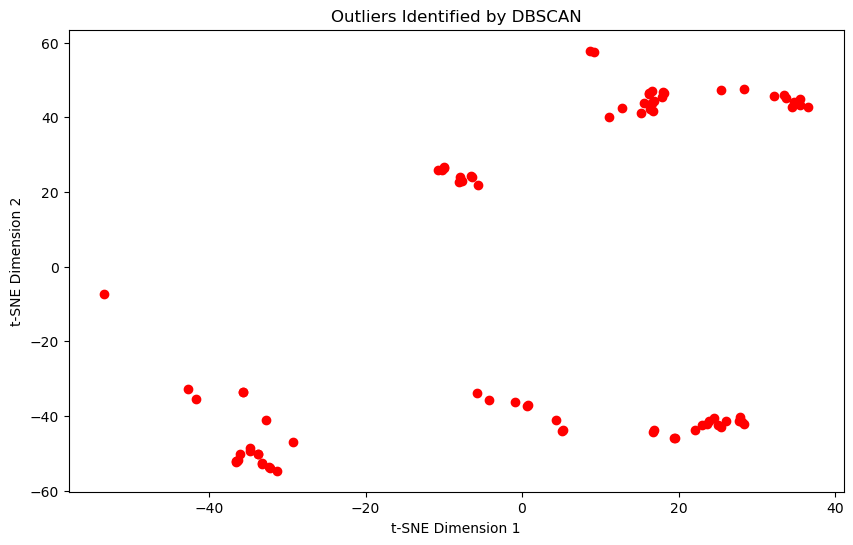

In [13]:
# Filter out the outlier points
outlier_points = tsne_results[dbscan_labels == -1]

# Create a scatter plot for the outliers
plt.figure(figsize=(10, 6))
plt.scatter(outlier_points[:, 0], outlier_points[:, 1], color='red')
plt.title('Outliers Identified by DBSCAN')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [14]:
outlier_index = np.where(dbscan_labels==-1)

filtered_data = np.delete(itemset_features, outlier_index, axis=0)
filtered_labels = np.delete(true_labels, outlier_index, axis=0)
print(len(filtered_labels), len(true_labels))

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
filtered_itemset_matrix = csr_matrix(filtered_data.astype(int))

spherical_kmeans = SphericalKMeans(
        n_clusters=11,
        max_iter=100,
        verbose=0,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

results = []
i = 0

while len(results)<10:
    try:
        filtered_sphkmeans_cluster_labels = spherical_kmeans.fit_predict(filtered_itemset_matrix)
        i+=1
        print('\nRun #' + str(i))
        result = compare_true_labels(filtered_labels, filtered_sphkmeans_cluster_labels, filtered_data)
        results.append(result)
    except Exception as e:
        # sometimes spherical clustering fails due to the initialization, re-run
        print(e)
        continue 

4917 5000

Run #1
Adjusted Rand Index: 0.23891647501698418
Normalized Mutual Information: 0.3525491317010107
Homogeneity: 0.3589965446350571
Completeness: 0.34632921812866463
V-Measure: 0.35254913170101065
Silhouette Score: 0.08800585662079906

Run #2
Adjusted Rand Index: 0.2238420267440075
Normalized Mutual Information: 0.34924014514712914
Homogeneity: 0.355738332178047
Completeness: 0.3429751010073863
V-Measure: 0.34924014514712914
Silhouette Score: 0.08926927301987961

Run #3
Adjusted Rand Index: 0.23607287311296257
Normalized Mutual Information: 0.3557840938981042
Homogeneity: 0.36251509231303713
Completeness: 0.349298494639991
V-Measure: 0.3557840938981041
Silhouette Score: 0.08817565558319712

Run #4
Adjusted Rand Index: 0.21775911225803052
Normalized Mutual Information: 0.3462195921617497
Homogeneity: 0.3501524379119078
Completeness: 0.34237411110257554
V-Measure: 0.34621959216174975
Silhouette Score: 0.09062702858562338

Run #5
Adjusted Rand Index: 0.22993269727899568
Normalize

In [15]:
results = np.array(results)
column_medians = np.median(results, axis=0)

print("Median values")
print("ARI: " + str(column_medians[0]))
print("NMI: " + str(column_medians[1]))
print("Homogeneity: " + str(column_medians[2]))
print("Completeness: " + str(column_medians[3]))
print("V-Measure: " + str(column_medians[4]))
print("Silhouette: " + str(column_medians[5]))

Median values
ARI: 0.2268873620115016
NMI: 0.34774122292847276
Homogeneity: 0.35398453257381046
Completeness: 0.3426746060549809
V-Measure: 0.34774122292847276
Silhouette: 0.08913993585867297


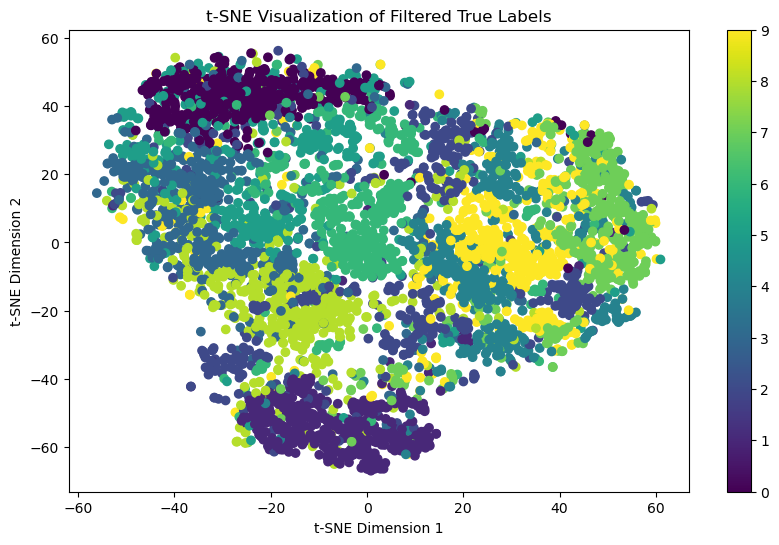

In [16]:
## using t-sne (alternative to pca) to visualize filtered true clusters

# Calculate cosine distances between binary vectors
#cosine_distances_matrix = cosine_distances(filtered_data)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="cosine", perplexity=50, learning_rate=5000/48, n_iter=3000, n_jobs=-1)

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(filtered_data)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))


plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Filtered True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


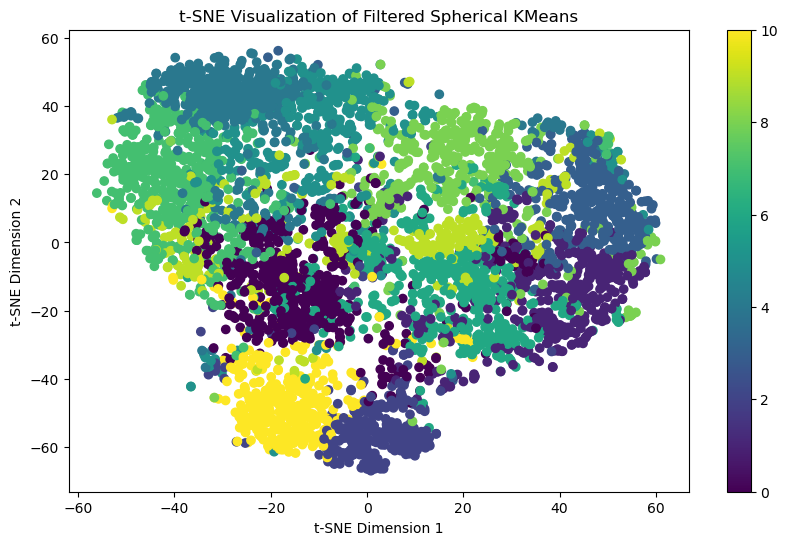

In [17]:
## using t-sne (alternative to pca) to visualize filtered SPHKMEANS clusters

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Filtered Spherical KMeans')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


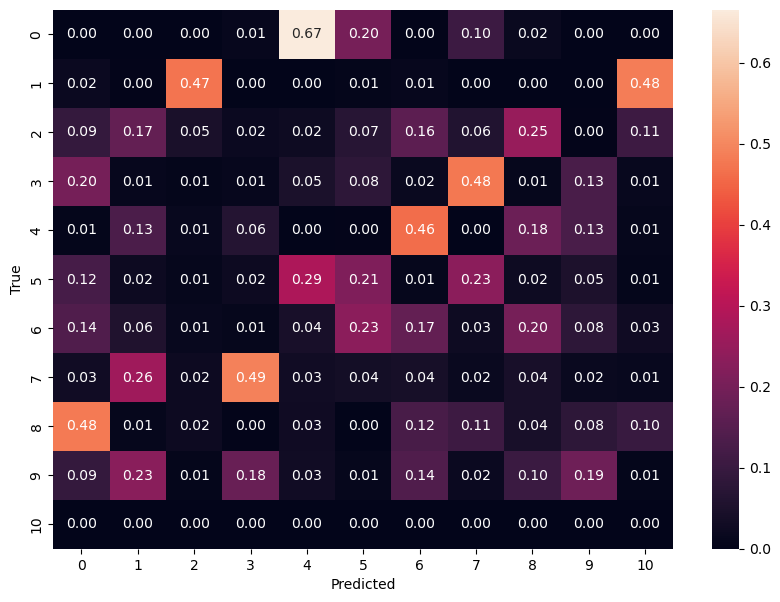

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(filtered_labels, filtered_sphkmeans_cluster_labels, normalize='true')

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()